In [1]:
import os
import xarray as xr
import geopandas as gpd


import ultraplot as uplt # 全局设置普通字体和数学字体 
uplt.rc['font.family'] = ['Times New Roman', 'FangSong'] 
uplt.rc['mathtext.fontset'] = 'stix'


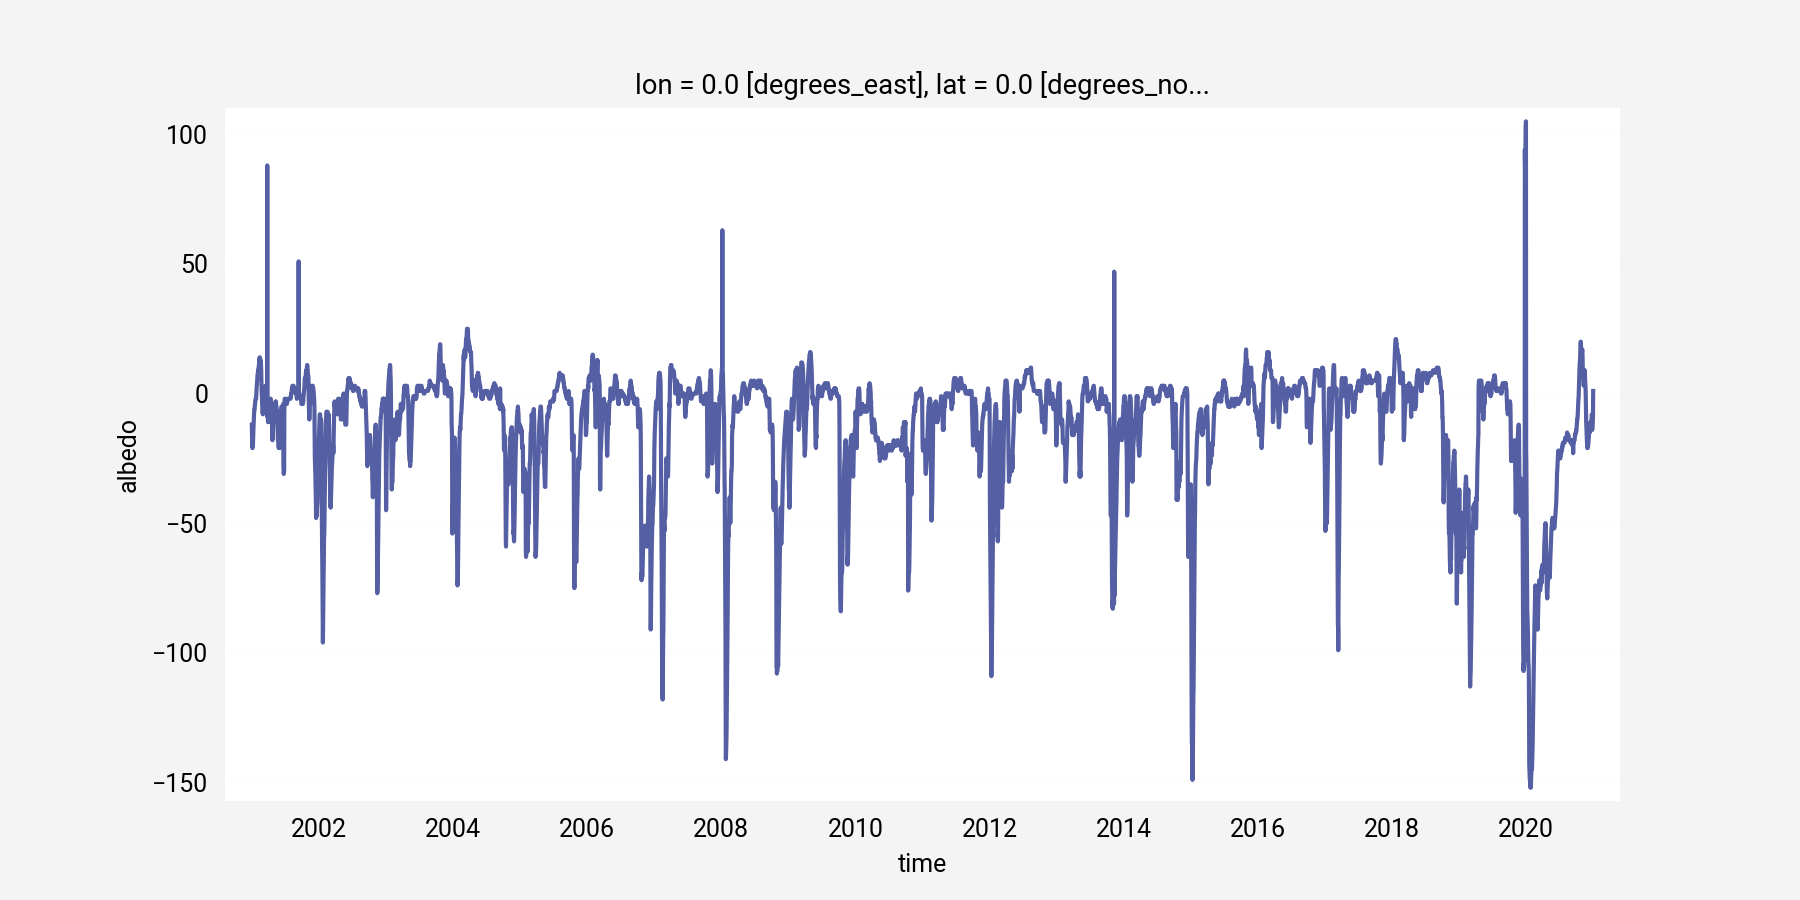

In [4]:
data_dir = '/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water'
fldmean_file = 'albedo_fldmean_anomaly_without_water_2001-2020.nc'
infile = os.path.join(data_dir,fldmean_file)
fldmean = xr.open_dataset(infile).albedo * (-1)
fldmean.plot(figsize=(9,4.5),
                  #  title='2001-2020多年逐日平均albedo',
                   )

In [2]:
fldmean_file = 'rf_albedo_without_water_2001-2020.nc'
infile = os.path.join(data_dir,fldmean_file)
fldmean = xr.open_dataset(infile)
fldmean.albedo_median.plot(figsize=(9,3),
                  #  title='2001-2020多年逐日平均albedo',
                   )
# fldmean


NameError: name 'data_dir' is not defined

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. 读取数据文件
data_dir = '/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water'
file_path = os.path.join(data_dir,'albedo_without_water_2001-2020.nc')
ds = xr.open_dataset(file_path)


# 1. 读取数据（使用dask支持的分块读取）
ds = xr.open_dataset(file_path, chunks={'time': 366})

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os
from datetime import datetime

# 1. 读取数据文件
data_dir = '/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water'
file_path = os.path.join(data_dir, 'albedo_without_water_2001-2019.nc')
ds = xr.open_dataset(file_path, chunks={'time': 366})
da = ds['albedo']

# 2. 添加月-日坐标
month_day = da.time.dt.strftime('%m-%d')

# 3. 分组计算中位数
daily_median = da.groupby(month_day).median(
    dim='time',
    skipna=True,
    keep_attrs=True
)

# 4. 创建2020年的日期序列（366天）
# 使用2020年作为基准年（闰年）
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
date_range = pd.date_range(start_date, end_date)

# 5. 重新索引数据以使用2020年日期
# 首先创建时间序列DataArray
date_coord = xr.DataArray(
    date_range,
    dims='time',
    name='time',
    attrs={'description': 'Calendar dates for 2020 (leap year)'}
)

# 6. 将数据重新分配到2020年时间坐标
result = daily_median.rename({'strftime': 'time'})
result['time'] = date_coord

# 7. 创建结果数据集并保存
result_ds = xr.Dataset({
    'albedo_median': result
})

# 添加元数据
result_ds.attrs['description'] = (
    "Median albedo for each calendar day calculated from daily observations "
    "during 2001-2019, mapped to 2020 calendar dates"
)
result_ds.attrs['creation_date'] = datetime.now().strftime("%Y-%m-%d")
result_ds.attrs['time_notes'] = "Dates represent 2020 calendar but data is aggregated from 2001-2020"

# 保留原始属性
result_ds.albedo_median.attrs.update(da.attrs)

# 8. 保存结果
output_path = os.path.join(data_dir, 'albedo_daily_median_2001-2020.nc')
result_ds.to_netcdf(output_path)

print("处理成功! 结果已保存至:", output_path)
print(f"结果包含 {len(result_ds.time)} 个日历日 (2020年日历)")
print(f"时间范围: {str(result_ds.time[0].values)[:10]} 至 {str(result_ds.time[-1].values)[:10]}")

/home/ninglk/bedrock/anaconda3/envs/earth/lib/python3.10/site-packages/dask/_task_spec.py:754: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


处理成功! 结果已保存至: /home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water/albedo_daily_median_2001-2020.nc
结果包含 366 个日历日 (2020年日历)
时间范围: 2020-01-01 至 2020-12-31


In [18]:
result_ds.albedo_median.day_of_year

<xarray.DataArray 'day_of_year' (day_of_year: 366)> Size: 3kB
array(['01-01', '01-02', '01-03', ..., '12-29', '12-30', '12-31'], dtype=object)
Coordinates:
  * day_of_year  (day_of_year) object 3kB '01-01' '01-02' ... '12-30' '12-31'

### 重建多年序列（中位数填充）

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# 读取原始数据（包含2020年的逐日反照率）
ds = xr.open_dataset('/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water/albedo_median_2001-2020.nc')
albedo_2020 = ds['albedo_median']  # 假设变量名为'albedo'

# 生成2001-2020年的完整日期范围
dates = pd.date_range('2001-01-01', '2020-12-31')

# 创建空白数据数组（时间×纬度×经度）
new_albedo = xr.DataArray(
    dims=('time', 'lat', 'lon'),
    coords={
        'time': dates,
        'lat': albedo_2020.lat,
        'lon': albedo_2020.lon
    },
    name='albedo'
)

# 提取2020年的月-日索引
month_day_index = albedo_2020['time'].dt.strftime('%m-%d')

# 逐日填充2001-2020年序列
for date in dates:
    # 计算当前日期的月-日
    md = date.strftime('%m-%d')
    
    try:
        # 从2020年找到相同月-日的数据
        source_data = albedo_2020.sel(time=month_day_index == md)
        new_albedo.loc[dict(time=date)] = source_data.values[0]
    except IndexError:
        # 处理闰年的2月29日
        if (date.month == 2) and (date.day == 29):
            # 用2月28日或3月1日替代（这里使用2月28日）
            replacement = albedo_2020.sel(time=month_day_index == '02-28').values[0]
            new_albedo.loc[dict(time=date)] = replacement

# 创建新的数据集并保存
new_ds = xr.Dataset({'albedo': new_albedo})
new_ds.to_netcdf('/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water/albedo_full_2001-2020.nc')

In [19]:
# 1. 读取数据文件
data_dir = '/home/ninglk/Chooyu/1_albedo/2Apr25/albedo_yr_without_water'
file_path = os.path.join(data_dir,'albedo_daily_median_2001-2020.nc')
ds = xr.open_dataset(file_path)

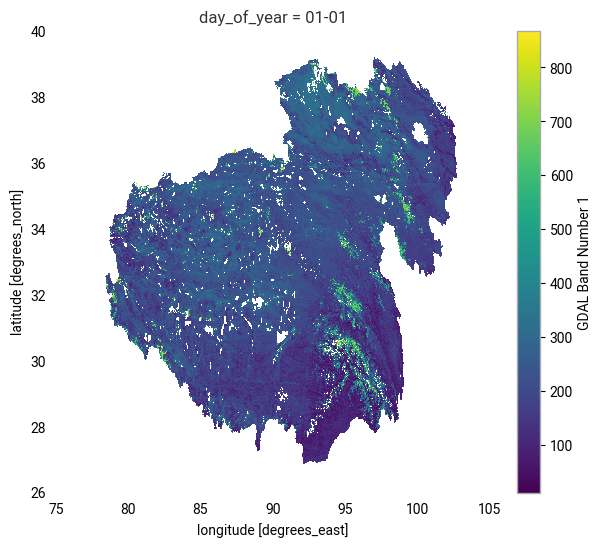

In [25]:
ds.albedo_median[0,:,:].plot()